# Replicating ResNet as done in Nakkirran et al. to reproduce double descent

In [1]:
# Let's import the necessary libraries
import torch
import torch.nn.functional as F
import torchvision
import torch.nn as nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
import wandb
from torch.utils.data import TensorDataset, Subset, DataLoader, Dataset
from torchvision import datasets, transforms

/Users/sienkadounia/anaconda3/envs/playground/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")

device = 'mps' # 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
on_colab = False
use_adam_op = True
augmented = True
use_label_noise = True
pytorch_default_resnet = True
model_width = 64
num_classes = 10
frac_label_noise = 0.15
mean_value = 0.5
std_value = 0.5
batch_size = 128
lr = 0.0001
epochs = 1500
model_seed = 42
data_seed = 42

In [4]:
'''if on_colab == True:
    from google.colab import drive
    drive.mount('/conten/gdrive')'''

"if on_colab == True:\n    from google.colab import drive\n    drive.mount('/conten/gdrive')"

In [5]:
## ResNet18 for CIFAR
## Based on: https://gitlab.com/harvard-machine-learning/double-descent/-/blob/master/models/resnet18k.py

class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, **kwargs):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out

class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, init_channels=64):
        super(PreActResNet, self).__init__()
        self.in_planes = init_channels
        c = init_channels

        self.conv1 = nn.Conv2d(3, c, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, c, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 2*c, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 4*c, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 8*c, num_blocks[3], stride=2)
        self.linear = nn.Linear(8*c*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        # eg: [2, 1, 1, ..., 1]. Only the first one downsamples.
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def make_resnet18k(k, num_classes) -> PreActResNet:
    ''' Returns a ResNet18 with width parameter k. (k=64 is standard ResNet18)'''
    return PreActResNet(PreActBlock, [2, 2, 2, 2], num_classes=num_classes, init_channels=k)

In [6]:
# Let's also import the standard resnet from PyTorch
resnet_pytorch = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

Using cache found in /Users/sienkadounia/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/sienkadounia/anaconda3/envs/playground/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sienkadounia/anaconda3/envs/playground/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
#We need to put the number of classes in the output layer of the PyTorch layer to macth our number of classes 10
resnet_pytorch.fc = nn.Linear(512, num_classes)

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
print(resnet_pytorch.parameters)
print(f"The number of parameters is: {count_parameters(resnet_pytorch)}")

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [10]:
if model_seed is not None:
    torch.manual_seed(model_seed)

resnet = make_resnet18k(model_width, num_classes)
resnet.to(device)
print(resnet.parameters)
print(f"The number of parameters is: {count_parameters(resnet)}")

<bound method Module.parameters of PreActResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1): Sequential(
    (0): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): PreActBlock(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (layer2): Sequential(
    (0): Pr

In [11]:
# Let's import the CIFAR10 dataset from torchvision
transform = transforms.Compose([transforms.ToTensor()]) if not augmented else transforms.Compose([transforms.ToTensor(), transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

if data_seed is not None:
    torch.manual_seed(data_seed)

train_set = datasets.CIFAR10(root='./data',
                             train=True,
                             download=True,
                             transform=transform)
trainloader = DataLoader(train_set,
                         batch_size=batch_size,
                         shuffle=True
                         )

test_set = datasets.CIFAR10(root='./data',
                            train=False,
                            download=True,
                            transform=transform)
testloader = DataLoader(test_set,
                        shuffle=False,
                        batch_size=batch_size
                        )

Files already downloaded and verified
Files already downloaded and verified


In [12]:
# This was not efficient so I had to find another way to do it
class LabelNoiseDataLoader(DataLoader):
    def __init__(self, original_dataset: Dataset, frac_label_noise: float, train=True, **kwargs) -> None:
    #def __init__(self, original_data, original_labels, frac_label_noise: float, train=True, **kwargs) -> None:
        self.frac_label_noise = frac_label_noise
        self.original = DataLoader(original_dataset, **kwargs)

        # Create a copy of the dataset with noise applied
        data, labels = torch.from_numpy(self.original.dataset.data).clone(), torch.from_numpy(np.array(self.original.dataset.targets)).unsqueeze(1).clone()

        # Change data to float32
        labels, _, corrupt_indices = self.apply_noise(labels, frac_label_noise=frac_label_noise)
        data = data.permute(0, 3, 2, 1)/255
        m = torch.mean(data, dim=[1, 2, 3], keepdim=True)
        mean = torch.full_like(m, mean_value)
        std = torch.full_like(m, std_value)
        data = data if not augmented else (data - mean)/std
        dataset = TensorDataset(data, labels.squeeze(1))

        # Create subset of samples in dataset without noise
        uncorrupted_indices = [i for i in range(len(dataset)) if i not in corrupt_indices]
        uncorrupted_subset = Subset(dataset, uncorrupted_indices)
        self.uncorrupted = DataLoader(uncorrupted_subset, **kwargs)

        # Create subset of samples in dataset with noise
        corrupted_subset = Subset(dataset, corrupt_indices)
        if not frac_label_noise:
            self.corrupted = []
        else:
            self.corrupted = DataLoader(corrupted_subset, **kwargs)

        super().__init__(dataset, **kwargs)

    @staticmethod
    def apply_noise(true_targets, frac_label_noise: float):
        # Apply label noise
        labels = true_targets.clone()

        if frac_label_noise > 0:
            num_noise = int(frac_label_noise * len(true_targets))
            corrupt_indices = torch.randperm(len(true_targets))[:num_noise]
            noise_to = corrupt_indices.roll(1)
            true_targets[corrupt_indices] = true_targets[noise_to]

            # TODO: Make sure the noise_to doesn't accidentally end up with the correct labels
            while (true_targets[corrupt_indices] == labels[noise_to]).any():
                repeating_indices = torch.where(true_targets[corrupt_indices] == labels[noise_to])[0]
                new_indices = torch.randperm(repeating_indices.nelement())
                true_targets[repeating_indices] = true_targets[new_indices]

            true_targets[corrupt_indices] = true_targets[corrupt_indices]
        else:
            corrupt_indices = torch.tensor([], dtype=torch.long)

        return labels, true_targets, corrupt_indices

In [13]:
np.random.seed(data_seed)
num_noise = int(frac_label_noise * len(trainloader.dataset.data))
true_targets = trainloader.dataset.targets

labels = torch.from_numpy(np.array(true_targets)).clone()
corrupt_indices = np.random.permutation(len(true_targets))[:num_noise]
check_labels = labels[corrupt_indices].tolist() # I will use this to cross-chec
labels, corrupt_indices, labels[corrupt_indices], check_labels, np.unique(labels[corrupt_indices].tolist(), return_counts=True)

(tensor([6, 9, 9,  ..., 9, 1, 1]),
 array([33553,  9427,   199, ...,  6166, 35101,  3594]),
 tensor([7, 8, 0,  ..., 8, 3, 3]),
 [7,
  8,
  0,
  6,
  1,
  6,
  8,
  0,
  6,
  5,
  2,
  5,
  0,
  7,
  1,
  6,
  5,
  6,
  6,
  5,
  0,
  5,
  7,
  2,
  4,
  4,
  5,
  5,
  4,
  8,
  4,
  3,
  5,
  0,
  0,
  8,
  0,
  1,
  8,
  0,
  3,
  0,
  0,
  0,
  9,
  4,
  4,
  6,
  7,
  6,
  9,
  0,
  9,
  9,
  4,
  3,
  6,
  2,
  9,
  9,
  8,
  4,
  4,
  8,
  1,
  1,
  3,
  9,
  1,
  5,
  0,
  3,
  0,
  2,
  2,
  7,
  8,
  3,
  1,
  8,
  7,
  5,
  4,
  0,
  5,
  7,
  8,
  1,
  1,
  4,
  8,
  3,
  2,
  2,
  5,
  9,
  7,
  7,
  8,
  8,
  3,
  4,
  6,
  1,
  7,
  8,
  3,
  7,
  1,
  7,
  6,
  4,
  3,
  0,
  4,
  6,
  0,
  8,
  3,
  3,
  8,
  9,
  6,
  5,
  1,
  4,
  9,
  2,
  4,
  3,
  2,
  4,
  1,
  0,
  1,
  6,
  4,
  2,
  8,
  2,
  7,
  1,
  3,
  6,
  5,
  8,
  8,
  5,
  4,
  6,
  4,
  1,
  3,
  7,
  1,
  7,
  8,
  7,
  1,
  1,
  2,
  5,
  9,
  1,
  9,
  2,
  4,
  5,
  5,
  2,
  2,
  3,
  6,
  3,
  5

In [14]:
# Let's define the function to make the derangement
import random
def D(l):
 o = l[:]
 while any(x==y for x,y in zip(o,l)):
   random.shuffle(o)
 return o

In [15]:
len(check_labels)

7500

In [16]:
# Let's initiate the derangement
deranged = []
increment = 100
start = 0
random.seed(data_seed)
for i in range(75):
    if i == 0:
        deranged.extend(D(check_labels[:increment]))
        start += 100
        print(start)
    else:
        deranged.extend(D(check_labels[start:increment*(i+1)]))
        start += 100
        print(start)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500


In [17]:
len(deranged)

7500

In [18]:
np.where(deranged == check_labels), type(deranged), type(check_labels)

((array([], dtype=int64),), list, list)

In [19]:
checker = labels[corrupt_indices]
checker

tensor([7, 8, 0,  ..., 8, 3, 3])

In [20]:
deranged

[1,
 2,
 5,
 1,
 8,
 1,
 5,
 9,
 9,
 8,
 8,
 0,
 5,
 9,
 6,
 0,
 8,
 2,
 0,
 8,
 6,
 1,
 4,
 6,
 5,
 1,
 6,
 1,
 2,
 6,
 3,
 7,
 6,
 5,
 5,
 4,
 7,
 9,
 7,
 5,
 7,
 9,
 6,
 9,
 0,
 8,
 0,
 8,
 8,
 7,
 4,
 6,
 8,
 3,
 7,
 4,
 5,
 4,
 8,
 7,
 1,
 3,
 0,
 0,
 0,
 4,
 5,
 4,
 6,
 0,
 4,
 2,
 1,
 3,
 8,
 1,
 0,
 5,
 0,
 4,
 2,
 7,
 9,
 3,
 2,
 4,
 3,
 0,
 0,
 5,
 4,
 8,
 3,
 7,
 2,
 8,
 0,
 9,
 5,
 0,
 6,
 7,
 5,
 8,
 6,
 1,
 6,
 9,
 2,
 3,
 1,
 3,
 4,
 2,
 5,
 3,
 7,
 4,
 0,
 1,
 7,
 1,
 2,
 4,
 2,
 9,
 1,
 6,
 1,
 7,
 9,
 6,
 7,
 5,
 0,
 3,
 3,
 5,
 7,
 8,
 5,
 9,
 2,
 1,
 8,
 2,
 1,
 0,
 1,
 1,
 2,
 8,
 1,
 2,
 6,
 1,
 4,
 8,
 7,
 9,
 3,
 8,
 5,
 4,
 5,
 4,
 9,
 7,
 4,
 4,
 5,
 5,
 4,
 8,
 7,
 3,
 1,
 0,
 8,
 3,
 3,
 2,
 6,
 3,
 5,
 8,
 2,
 1,
 4,
 6,
 4,
 3,
 8,
 6,
 1,
 8,
 4,
 5,
 6,
 3,
 7,
 8,
 7,
 3,
 3,
 2,
 1,
 4,
 5,
 4,
 2,
 7,
 1,
 7,
 4,
 2,
 4,
 5,
 4,
 5,
 4,
 9,
 8,
 9,
 7,
 8,
 1,
 4,
 5,
 0,
 8,
 7,
 9,
 9,
 0,
 5,
 0,
 7,
 9,
 2,
 0,
 9,
 6,
 0,
 5,
 4,
 2,
 1,
 5,
 3,


In [21]:
'''import pandas as pd
achieved_label_noise = np.array(deranged)
achieved_label_noise = pd.DataFrame(achieved_label_noise)
achieved_label_noise.to_csv("fifteen_percent_label_noise.csv", index=False)'''

'import pandas as pd\nachieved_label_noise = np.array(deranged)\nachieved_label_noise = pd.DataFrame(achieved_label_noise)\nachieved_label_noise.to_csv("fifteen_percent_label_noise.csv", index=False)'

In [22]:
labels[corrupt_indices] = torch.from_numpy(np.array(deranged))
labels[corrupt_indices]

tensor([1, 2, 5,  ..., 6, 6, 4])

In [23]:
torch.where(checker == labels[corrupt_indices])

(tensor([], dtype=torch.int64),)

In [24]:
torch.unique(checker, return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([721, 734, 769, 768, 704, 763, 749, 755, 771, 766]))

In [25]:
torch.unique(labels[corrupt_indices], return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([721, 734, 769, 768, 704, 763, 749, 755, 771, 766]))

In [26]:
torch.where(checker == labels[corrupt_indices])

(tensor([], dtype=torch.int64),)

In [27]:
repeated = torch.where(checker == labels[corrupt_indices])[0]
repeat_labels = labels[repeated].tolist()
len(repeat_labels)

0

In [28]:
'''re_deranged = []
increment = 100
start = 0
for i in range(9):
    if i == 0:
        re_deranged.extend(D(repeat_labels[:increment]))
        start += 100
        print(start)
    elif i < 8:
        re_deranged.extend(D(repeat_labels[start:increment*(i+1)]))
        start += 100
        print(start)
    else:
        re_deranged.extend(D(repeat_labels[increment*i:]))'''

're_deranged = []\nincrement = 100\nstart = 0\nfor i in range(9):\n    if i == 0:\n        re_deranged.extend(D(repeat_labels[:increment]))\n        start += 100\n        print(start)\n    elif i < 8:\n        re_deranged.extend(D(repeat_labels[start:increment*(i+1)]))\n        start += 100\n        print(start)\n    else:\n        re_deranged.extend(D(repeat_labels[increment*i:]))'

In [29]:
labels == trainloader.dataset.targets, torch.unique(labels, return_counts=True)

(False,
 (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
  tensor([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000])))

In [30]:
np.unique(trainloader.dataset.targets, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

In [31]:
proof = trainloader.dataset.targets

In [32]:
labels = labels.tolist()

In [33]:
proof == labels, type(proof), type(labels)

(False, list, list)

In [34]:
'''torch.manual_seed(data_seed)
new_dataloader = LabelNoiseDataLoader(train_set, fac_label_noise, batch_size=batch_size)'''

'torch.manual_seed(data_seed)\nnew_dataloader = LabelNoiseDataLoader(train_set, fac_label_noise, batch_size=batch_size)'

In [35]:
#list(new_dataloader)

In [36]:
list(trainloader)

[[tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
            [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
            [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
            ...,
            [-0.4745, -0.2000, -0.4824,  ..., -0.4980, -1.0000, -1.0000],
            [-0.2784, -0.3020, -0.4039,  ..., -0.3020, -1.0000, -1.0000],
            [-0.1765, -0.3490, -0.2784,  ..., -0.1373, -1.0000, -1.0000]],
  
           [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
            [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
            [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
            ...,
            [-0.1373,  0.1059, -0.1373,  ...,  0.0118, -1.0000, -1.0000],
            [ 0.1216,  0.0824,  0.0510,  ...,  0.3333, -1.0000, -1.0000],
            [ 0.2627,  0.0824,  0.2392,  ...,  0.5922, -1.0000, -1.0000]],
  
           [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.000

In [37]:
# Let's change the labels in the initial trainloader with the noisy labels
if use_label_noise:
    trainloader.dataset.targets = labels

In [38]:
proof2 = trainloader.dataset.targets

In [39]:
# Let's cross-check for any mistake
proof2 == proof

False

In [40]:
criterion = nn.CrossEntropyLoss()
model = resnet if not pytorch_default_resnet else resnet_pytorch
model.to(device)
optimizer = optim.SGD(model.parameters(), lr, momentum=0.9, weight_decay=5e-10) if not use_adam_op else optim.Adam(model.parameters(), lr)
dl = trainloader #if not use_label_noise else new_dataloader
count_parameters(model) # Cross-checking the model is the right one

11181642

In [41]:
wandb.init(project="SLT of Double Descent",
           config = {'epochs': epochs,
                     'classes': num_classes,
                     'learning_rate': lr,
                     'use_label_noise': use_label_noise,
                     'noise_level': frac_label_noise,
                     'dataset': "CIFAR10",
                     'architecture': "ResNet18",
                     'pytorch_resnet_model': pytorch_default_resnet,
                     'model_width': model_width,
                     'augmented': augmented,
                     'adam optimizer': use_adam_op}
                     )

wandb.watch(resnet)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sienka. Use `wandb login --relogin` to force relogin


In [42]:
print("Training on", device)

test_losses = []
train_losses = []
train_accs = []
test_accs = []

step = 0

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    train_acc = 0.0

    for i, data in enumerate(dl):
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      outputs = model(images)
      batch_loss = criterion(outputs, labels)

      predictions = outputs.argmax(axis=-1)
      train_acc += torch.sum(predictions == labels).item()
      train_loss += batch_loss.item()

      batch_loss.backward()
      optimizer.step()

      step += 1

      wandb.log({'batch_loss': batch_loss.item()}, step=step)

    # Calculate average training loss for the epoch
    train_loss /= len(trainloader.dataset.data)
    train_acc /= len(trainloader.dataset.data)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation (or test) loop
    model.eval()

    test_loss = 0.0
    test_acc = 0.0

    with torch.no_grad():
        for j, test_data in enumerate(testloader):
            test_images, test_labels = test_data
            test_images = test_images.to(device)
            test_labels = test_labels.to(device)

            outputs = model(test_images)
            batch_test_loss = criterion(outputs, test_labels)
            test_loss += batch_test_loss.item()

            predictions = outputs.argmax(axis=-1)
            test_acc += torch.sum(predictions == test_labels).item()

    # Let's calculate average test loss for the epoch
    test_loss /= len(testloader.dataset.data)
    test_acc /= len(testloader.dataset.data)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    wandb.log({'epoch': epoch,
               'loss/train': train_loss,
               'loss/test': test_loss,
               'accuracy/train': train_acc,
               'accuracy/test': test_acc
           }, step=step)

    # Print or log the training and test losses for each epoch
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    if epoch % 10 == 0:
      checkpoint = {
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optim_state': optimizer.state_dict()
      }

      prefix = 'checkpoint' if not use_label_noise else'checkpoint-with-noise'
      FILENAME = prefix+str(epoch)+'.pth'
      Path = f'/content/gdrive/My Drive/{FILENAME}'
      torch.save(checkpoint, FILENAME) if not on_colab else torch.save(checkpoint, Path)
    '''if use_adam_op == False:
       scheduler.step()'''
wandb.finish()

Training on mps
Epoch 1/1500, Train Loss: 0.0156, Test Loss: 0.0130
Epoch 2/1500, Train Loss: 0.0141, Test Loss: 0.0119
Epoch 3/1500, Train Loss: 0.0134, Test Loss: 0.0112
Epoch 4/1500, Train Loss: 0.0129, Test Loss: 0.0105
Epoch 5/1500, Train Loss: 0.0124, Test Loss: 0.0101
Epoch 6/1500, Train Loss: 0.0121, Test Loss: 0.0098
Epoch 7/1500, Train Loss: 0.0117, Test Loss: 0.0093
Epoch 8/1500, Train Loss: 0.0115, Test Loss: 0.0092
Epoch 9/1500, Train Loss: 0.0112, Test Loss: 0.0087
Epoch 10/1500, Train Loss: 0.0110, Test Loss: 0.0085
Epoch 11/1500, Train Loss: 0.0108, Test Loss: 0.0085
Epoch 12/1500, Train Loss: 0.0106, Test Loss: 0.0081
Epoch 13/1500, Train Loss: 0.0104, Test Loss: 0.0080
Epoch 14/1500, Train Loss: 0.0103, Test Loss: 0.0080
Epoch 15/1500, Train Loss: 0.0102, Test Loss: 0.0078
Epoch 16/1500, Train Loss: 0.0100, Test Loss: 0.0079
Epoch 17/1500, Train Loss: 0.0099, Test Loss: 0.0078
Epoch 18/1500, Train Loss: 0.0098, Test Loss: 0.0076
Epoch 19/1500, Train Loss: 0.0096, Test

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [43]:
final_checkpoint = {
  'epoch': epoch,
  'model_state': model.state_dict(),
  'optim_state': optimizer.state_dict()
}

prefixf = 'final_checkpoint' if not use_label_noise else'final_checkpoint-with-noise'
FINAL_FILENAME = prefixf+'.pth'
Path = f'/content/gdrive/My Drive/{FINAL_FILENAME}'
torch.save(final_checkpoint, FINAL_FILENAME) if not on_colab else torch.save(final_checkpoint, Path)

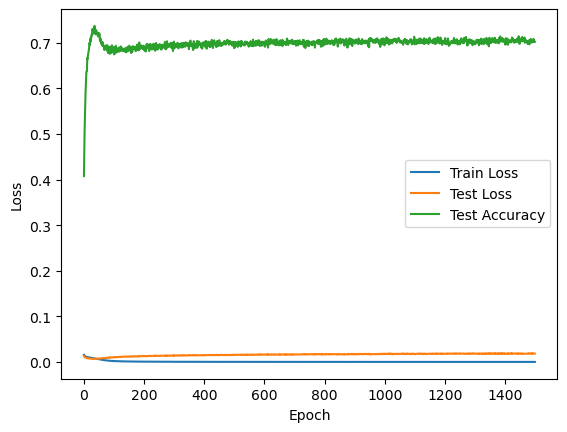

In [44]:
# Plot the training and test losses
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [45]:
import pandas as pd
trl = np.array(train_losses)
tel = np.array(test_losses)
teac = np.array(test_accs)
trl = pd.DataFrame(trl)
tel = pd.DataFrame(tel)
teac = pd.DataFrame(teac)
trl.to_csv("clean_train_losses.csv", index=False) if not use_label_noise else trl.to_csv("train_losses_with_label_noise.csv", index=False)
tel.to_csv("clean_test_losses.csv", index=False) if not use_label_noise else tel.to_csv("test_losses_with_label_noise.csv", index=False)
teac.to_csv("clean_test_accs.csv", index=False) if not use_label_noise else teac.to_csv("test_accs_with_label_noise.csv", index=False)

# Estimating the Learning Coefficients (RLCTs)

In [169]:
import seaborn
import yaml
import devinterp
from devinterp.slt import estimate_learning_coeff, estimate_learning_coeff_with_summary
from devinterp.optim.sgld import SGLD
from devinterp.utils import plot_trace

In [170]:
last_checkpoint = torch.load('final_checkpoint_with_noise.pth')

In [171]:
model = resnet if not pytorch_default_resnet else resnet_pytorch
optimizer = optimizer

In [173]:
model.load_state_dict(last_checkpoint['model_state'])
optimizer.load_state_dict(last_checkpoint['optim_state'])

In [174]:
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-3.0822e-02, -5.7558e-02, -2.0722e-02,  ..., -6.4116e-03,
                         -5.3747e-03, -1.2669e-02],
                        [ 4.0117e-03,  6.0931e-02,  1.2168e-02,  ..., -1.1698e-01,
                         -5.7423e-02,  3.0326e-02],
                        [-2.7688e-03, -8.2508e-02, -1.3774e-01,  ...,  6.2253e-02,
                          7.7147e-02, -1.7795e-02],
                        ...,
                        [-7.2950e-02,  1.3378e-02,  2.3237e-02,  ..., -3.0175e-02,
                         -4.1443e-04,  5.8483e-02],
                        [ 4.2826e-02,  2.1815e-04, -4.9127e-02,  ...,  3.1143e-02,
                          5.4171e-02, -4.3661e-02],
                        [-3.9894e-02, -3.2006e-02, -3.4234e-02,  ..., -3.5044e-02,
                         -7.7690e-02, -7.1479e-02]],
              
                       [[-7.0354e-02, -1.1224e-01, -3.5128e-02,  ..., -1.2141e-02,
                         -5.1928

In [175]:
optimizer.state_dict()

{'state': {0: {'step': tensor(586500.),
   'exp_avg': tensor([[[[ 4.3174e-04,  1.1715e-03,  1.4105e-03,  ..., -1.3336e-04,
              -1.6218e-03, -1.9136e-03],
             [ 1.7327e-03,  2.7386e-03,  2.4057e-03,  ...,  1.1366e-03,
               3.4952e-04, -3.6537e-04],
             [ 2.7936e-04,  1.2124e-03,  1.0400e-03,  ...,  6.9826e-04,
              -2.9088e-04, -1.4313e-03],
             ...,
             [ 3.4473e-04,  1.7213e-03,  1.3665e-03,  ..., -2.3808e-04,
              -8.7713e-04, -8.5588e-04],
             [ 2.3797e-04,  1.0277e-03,  8.0269e-04,  ..., -1.3279e-04,
              -9.2714e-04, -1.2630e-03],
             [ 6.4194e-05,  8.0482e-04,  1.2622e-03,  ...,  3.6843e-04,
              -7.8424e-04, -9.8395e-04]],
   
            [[-4.2682e-05,  5.5559e-04,  7.3529e-04,  ..., -5.0175e-04,
              -2.0490e-03, -2.2680e-03],
             [ 1.0095e-03,  1.7884e-03,  1.5946e-03,  ...,  7.4866e-04,
              -1.4109e-04, -7.4481e-04],
             [-6.8942e

In [176]:
torch.manual_seed(0)

final_rlcts = estimate_learning_coeff_with_summary(
    model,
    loader=trainloader,
    criterion=criterion,
    sampling_method=SGLD,
    optimizer_kwargs=dict(lr=lr, elasticity=1., num_samples=len(trainloader.dataset.data)),
    num_chains=5,  # How many independent chains to run
    num_draws=256,  # How many samples to draw per chain
    num_burnin_steps=0,  # How many samples to discard at the beginning of each chain
    num_steps_bw_draws=1,  # How many steps to take between each sample
    device=device,
)

Chain 4: 100%|██████████| 256/256 [00:20<00:00, 12.61it/s]


In [177]:
pref = 'sgd_' if not use_adam_op else 'adam_'
rlcts_final = pref + 'final_model_rlcts.pt' if not use_label_noise else pref + 'final_model_with_noise_rlcts.pt'
torch.save(final_rlcts, rlcts_final)

In [178]:
trace = final_rlcts.pop("loss/trace")

print("Lambda hat estimates: ")
print(yaml.dump(final_rlcts))

Lambda hat estimates: 
llc-chain/0: 13476.9853515625
llc-chain/1: 13649.435546875
llc-chain/2: 13329.927734375
llc-chain/3: 13573.5380859375
llc-chain/4: 13495.455078125
llc/mean: 13505.0693359375
llc/std: 119.462646484375



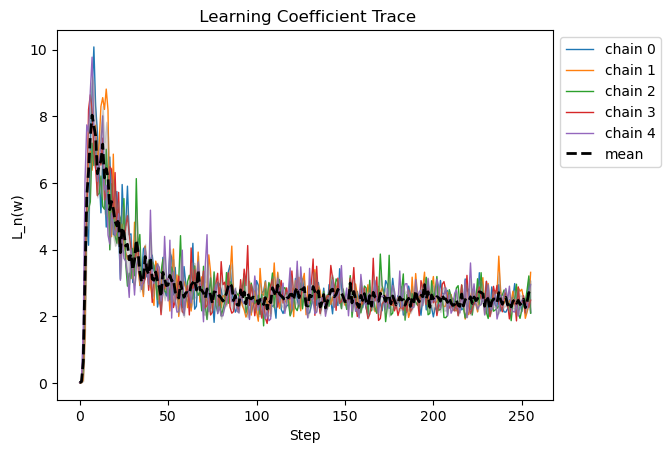

<Figure size 1200x900 with 0 Axes>

In [179]:
plot_trace(trace, 'L_n(w)', x_axis='Step', title=' Learning Coefficient Trace', plot_mean=False, plot_std=False, fig_size=(12, 9), true_lc = None)

Chain 4: 100%|██████████| 256/256 [00:19<00:00, 13.47it/s]


Lambda hat estimates for adam_checkpoint10: 
llc-chain/0: 7800.19921875
llc-chain/1: 7927.599609375
llc-chain/2: 7994.4111328125
llc-chain/3: 7789.58154296875
llc-chain/4: 8234.2666015625
llc/mean: 7949.2119140625
llc/std: 181.2821502685547



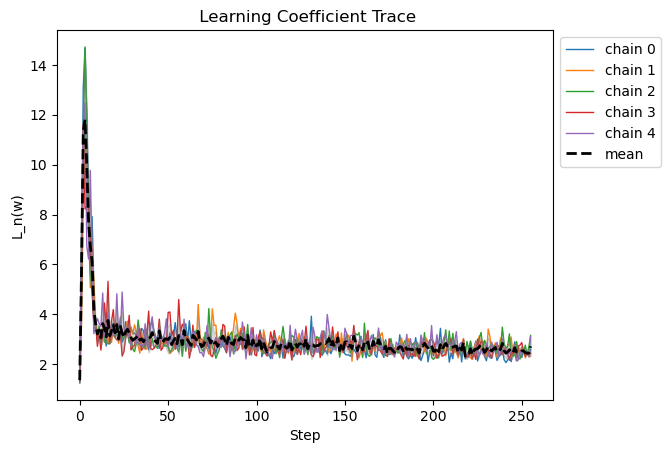

<Figure size 1200x900 with 0 Axes>

Chain 4: 100%|██████████| 256/256 [00:18<00:00, 13.51it/s]


Lambda hat estimates for adam_checkpoint100: 
llc-chain/0: 12515.35546875
llc-chain/1: 12730.9375
llc-chain/2: 12379.6376953125
llc-chain/3: 12427.1572265625
llc-chain/4: 12789.564453125
llc/mean: 12568.5302734375
llc/std: 182.8431854248047



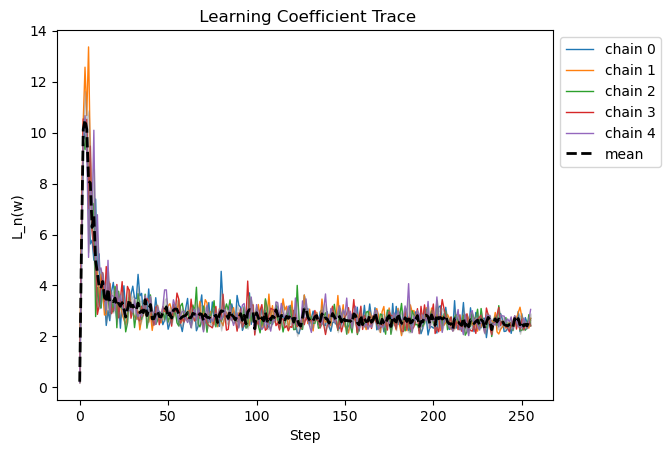

<Figure size 1200x900 with 0 Axes>

Chain 4: 100%|██████████| 256/256 [00:19<00:00, 13.23it/s]


Lambda hat estimates for adam_checkpoint200: 
llc-chain/0: 12832.5810546875
llc-chain/1: 12626.833984375
llc-chain/2: 12898.103515625
llc-chain/3: 13003.3779296875
llc-chain/4: 13211.2080078125
llc/mean: 12914.4208984375
llc/std: 215.4449920654297



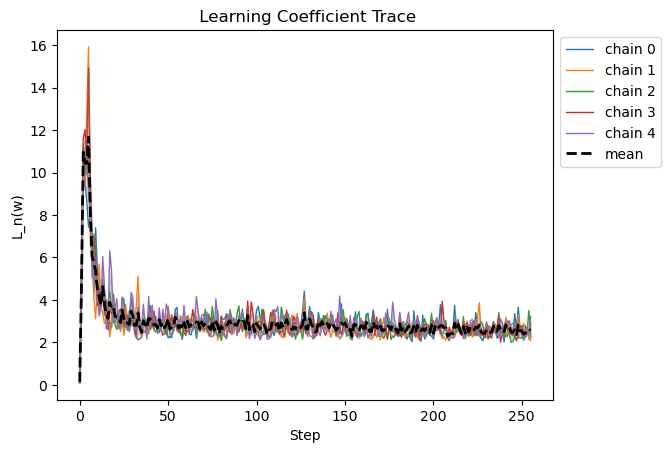

<Figure size 1200x900 with 0 Axes>

Chain 4: 100%|██████████| 256/256 [19:55<00:00,  4.67s/it]


Lambda hat estimates for adam_checkpoint300: 
llc-chain/0: 13409.8896484375
llc-chain/1: 13341.83984375
llc-chain/2: 14072.1611328125
llc-chain/3: 13292.4521484375
llc-chain/4: 13420.53125
llc/mean: 13507.375
llc/std: 320.00872802734375



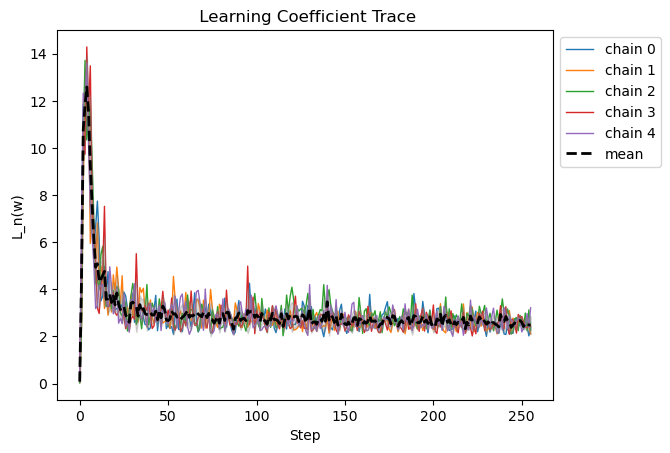

<Figure size 1200x900 with 0 Axes>

Chain 4: 100%|██████████| 256/256 [1:40:57<00:00, 23.66s/it]


Lambda hat estimates for adam_checkpoint400: 
llc-chain/0: 13125.974609375
llc-chain/1: 13192.3115234375
llc-chain/2: 13649.458984375
llc-chain/3: 13388.4365234375
llc-chain/4: 13450.939453125
llc/mean: 13361.4248046875
llc/std: 209.60813903808594



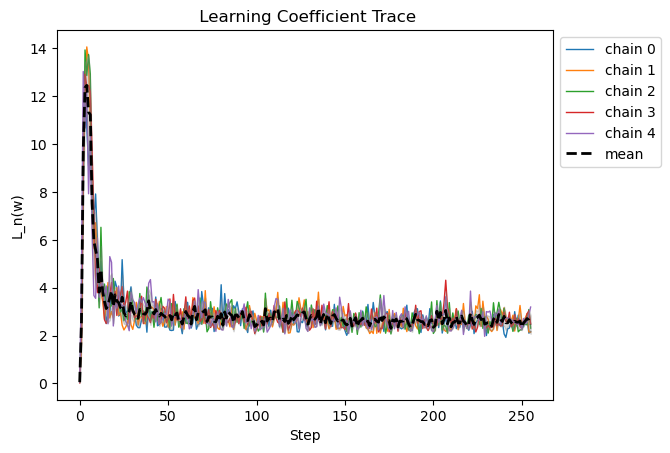

<Figure size 1200x900 with 0 Axes>

Chain 4: 100%|██████████| 256/256 [1:51:52<00:00, 26.22s/it]   


Lambda hat estimates for adam_checkpoint500: 
llc-chain/0: 13851.7138671875
llc-chain/1: 13570.240234375
llc-chain/2: 13869.775390625
llc-chain/3: 13969.314453125
llc-chain/4: 14247.599609375
llc/mean: 13901.728515625
llc/std: 243.72198486328125



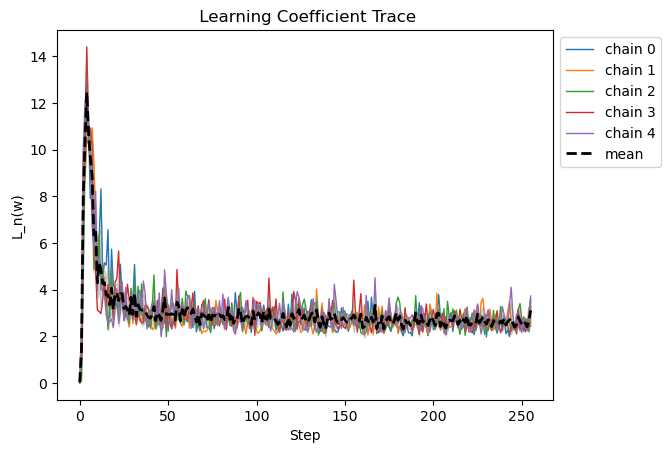

<Figure size 1200x900 with 0 Axes>

Chain 4: 100%|██████████| 256/256 [1:58:22<00:00, 27.75s/it]


Lambda hat estimates for adam_checkpoint600: 
llc-chain/0: 13384.0478515625
llc-chain/1: 13715.07421875
llc-chain/2: 14123.43359375
llc-chain/3: 13763.2490234375
llc-chain/4: 13523.67578125
llc/mean: 13701.8974609375
llc/std: 280.3666076660156



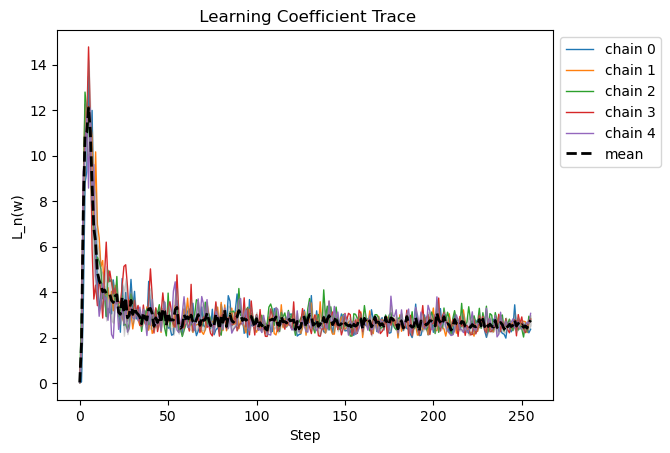

<Figure size 1200x900 with 0 Axes>

Chain 4: 100%|██████████| 256/256 [1:36:30<00:00, 22.62s/it]


Lambda hat estimates for adam_checkpoint700: 
llc-chain/0: 13592.3017578125
llc-chain/1: 14149.29296875
llc-chain/2: 13858.65625
llc-chain/3: 14013.9453125
llc-chain/4: 13656.3046875
llc/mean: 13854.1005859375
llc/std: 234.7187042236328



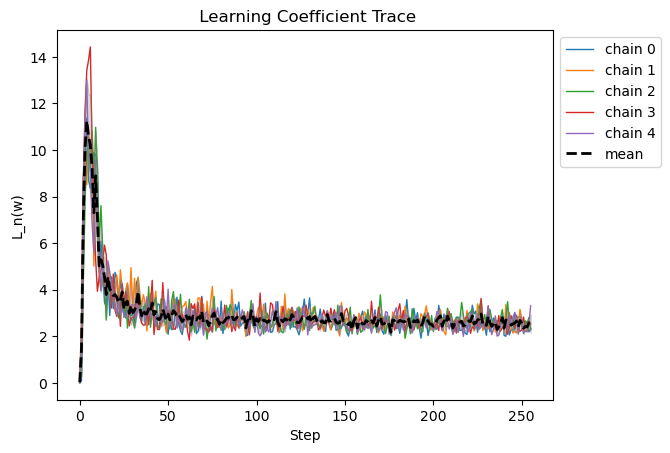

<Figure size 1200x900 with 0 Axes>

Chain 4: 100%|██████████| 256/256 [12:01:38<00:00, 169.14s/it]   


Lambda hat estimates for adam_checkpoint800: 
llc-chain/0: 13965.072265625
llc-chain/1: 13622.3134765625
llc-chain/2: 13522.486328125
llc-chain/3: 13499.47265625
llc-chain/4: 14288.91015625
llc/mean: 13779.650390625
llc/std: 340.2626037597656



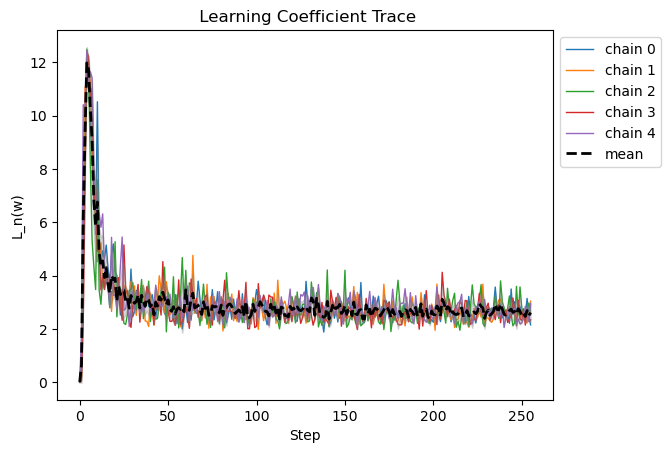

<Figure size 1200x900 with 0 Axes>

Chain 0:  50%|█████     | 129/256 [1:09:02<1:07:58, 32.11s/it]


KeyboardInterrupt: 

In [180]:
original_checkpoint = 'adam_checkpoint_with_noise'
name = 'sgd_checkpoint' if not use_adam_op else 'adam_checkpoint'
next = 100
for i in range(14):
    if i == 0:
            checkpoint_name = original_checkpoint + str(10) + '.pth'
            right_name = name + str(10)
            checkpoint = torch.load(checkpoint_name)
            model.load_state_dict(checkpoint['model_state'])

            torch.manual_seed(0)
            checkpoint_rlcts = estimate_learning_coeff_with_summary(
                model,
                loader=trainloader,
                criterion=criterion,
                sampling_method=SGLD,
                optimizer_kwargs=dict(lr=lr, elasticity=1., num_samples=len(trainloader.dataset.data)),
                num_chains=5,  # How many independent chains to run
                num_draws=256,  # How many samples to draw per chain
                num_burnin_steps=0,  # How many samples to discard at the beginning of each chain
                num_steps_bw_draws=1,  # How many steps to take between each sample
                device=device,
            )

            
            current_checkpoint = right_name + '_rlcts.pt' if not use_label_noise else right_name + '_with_noise' + '_rlcts.pt'
            torch.save(checkpoint_rlcts, current_checkpoint)

            trace = checkpoint_rlcts.pop("loss/trace")

            print(f"Lambda hat estimates for {right_name}: ")
            print(yaml.dump(checkpoint_rlcts))
            plot_trace(trace, 'L_n(w)', x_axis='Step', title=' Learning Coefficient Trace', plot_mean=False, plot_std=False, fig_size=(12, 9), true_lc = None)

    else:
        checkpoint_name = original_checkpoint + str(next) + '.pth'
        right_name = name + str(next)
        checkpoint = torch.load(checkpoint_name)
        model.load_state_dict(checkpoint['model_state'])

        torch.manual_seed(0)
        checkpoint_rlcts = estimate_learning_coeff_with_summary(
            model,
            loader=trainloader,
            criterion=criterion,
            sampling_method=SGLD,
            optimizer_kwargs=dict(lr=lr, elasticity=1., num_samples=len(trainloader.dataset.data)),
            num_chains=5,
            num_draws=256,
            num_burnin_steps=0,
            num_steps_bw_draws=1, 
            device=device,
        )

        current_checkpoint = right_name + '_rlcts.pt' if not use_label_noise else right_name + '_with_noise' + '_rlcts.pt'
        torch.save(checkpoint_rlcts, current_checkpoint)

        trace = checkpoint_rlcts.pop("loss/trace")

        print(f"Lambda hat estimates for {right_name}: ")
        print(yaml.dump(checkpoint_rlcts))
        plot_trace(trace, 'L_n(w)', x_axis='Step', title=' Learning Coefficient Trace', plot_mean=False, plot_std=False, fig_size=(12, 9), true_lc = None)
        
        next += 100